In [3]:
import xarray as xr, matplotlib, matplotlib.pyplot as plt, glob, os, re, geopandas as gpd, regionmask, cartopy, pandas as pd, numpy as np
matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box
from xhistogram.xarray import histogram
import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

import matplotlib.image as img; from PIL import Image    # to add .png to subplots

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/SEAsiaFloods/"

mapproj = cartopy.crs.PlateCarree()

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/miniforge3/envs/wwa/share/proj failed


In [37]:
! unzip URAU_RG_100K_2018_4326.shp.zip

Archive:  URAU_RG_100K_2018_4326.shp.zip
  inflating: URAU_RG_100K_2018_4326.cpg  
  inflating: URAU_RG_100K_2018_4326.dbf  
  inflating: URAU_RG_100K_2018_4326.prj  
  inflating: URAU_RG_100K_2018_4326.shp  
  inflating: URAU_RG_100K_2018_4326.shx  


In [38]:
sf = gpd.read_file("sf_URAU")

In [43]:
sf.loc[(sf.CNTR_CODE == "UK")]

,URAU_CODE,URAU_CATG,CNTR_CODE,URAU_NAME,CITY_CPTL,CITY_KERN,FUA_CODE,NUTS3_2016,geometry
1,UK002C1,C,UK,Birmingham,None,UK002K1,UK002L3,UKG31,"POLYGON ((-1.77797 52.57517, -1.77662 52.57458..."
2,UK003C1,C,UK,Leeds,None,None,UK003L2,UKE42,"POLYGON ((-1.33978 53.9456, -1.3428 53.94331, ..."
3,UK004C1,C,UK,Glasgow,None,UK004K1,UK004L1,UKM82,"POLYGON ((-4.27636 55.92974, -4.27079 55.92815..."
4,UK005C1,C,UK,Bradford,None,None,UK003L2,UKE41,"POLYGON ((-1.87989 53.95594, -1.87884 53.95431..."
5,UK006C1,C,UK,Liverpool,None,UK006K2,UK006L3,UKD72,"POLYGON ((-2.92255 53.47503, -2.91999 53.47332..."
...,...,...,...,...,...,...,...,...,...
1257,UK552K1,K,UK,Reading,None,None,None,UKJ11,"POLYGON ((-0.8625 51.54902, -0.85973 51.54837,..."
1260,UK553K1,K,UK,Blackpool,None,None,None,UKD44,"MULTIPOLYGON (((-2.71563 53.98029, -2.71102 53..."
1261,UK562K1,K,UK,Preston,None,None,None,UKD45,"POLYGON ((-2.64711 53.89483, -2.64672 53.89435..."
1265,UK580K1,K,UK,Rushmoor,None,None,None,UKJ25,"POLYGON ((-0.59797 51.3863, -0.59502 51.37837,..."


In [35]:
sf_sl.to_file("hydrorivers_sl")

In [28]:
list(set(sf_sl.ORD_FLOW))

[4, 5, 6, 7]

<Axes: >

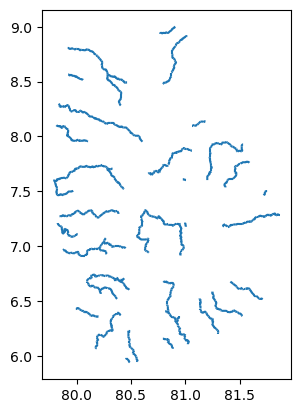

In [34]:
sf_sl.loc[sf_sl.ORD_FLOW == 5]

In [ ]:
! mkdir $fpath/mswep-y

# Create land mask for Sumatra region

In [ ]:
sf_rect = gpd.read_file(fpath+"sf_SumatraMalayThai")

sf_clipped = regionmask.defined_regions.natural_earth_v5_1_2.land_50.to_geodataframe().set_crs("EPSG:4326").clip(sf_rect)
sf_clipped.to_file(fpath+"sf_SumatraMalayThai-LAND")

# Seasonal anomaly maps

## Compile MSWEP data

In [ ]:
# # compile MSWEP data into yearly chunks
# for y in range(1979,2026):
#     print(y)
#     new_fnm = fpath+"mswep-y/mswep-sea_"+str(y)+".nc"
#     if os.path.exists(new_fnm): continue

#     ! module load CDO/2.4.4-gompi-2024a; cdo mergetime $fpath/mswep/$y*.nc $new_fnm

In [ ]:
# merge into a single file, trim & apply land-sea mask
ds = xr.open_mfdataset(fpath+"mswep-y/*.nc").precip.sel(lat = slice(None, 20))

rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(ds)
ds_masked = ds.where(rm == 0)

In [ ]:
ds_masked.to_netcdf(fpath+"mswep_SEAsia.nc")

## Map of long-term anomaly

In [7]:
ds_nm = "cpc"
da = xr.open_dataset(fpath+ds_nm+"_SEAsia.nc")
da = da[list(da.data_vars)[0]]

In [8]:
nov_2025 = da.sel(time = "2025-11").mean("time")
nov_clim = da.sel(time = slice("1991","2020")).groupby("time.month")[11].mean("time")
nov_anom = nov_2025 - nov_clim
nov_relanom = nov_anom / nov_clim

In [ ]:
son_2025 = da.sel(time = "2025").groupby("time.season")["SON"].mean("time")
son_clim = da.sel(time = slice("1991","2020")).groupby("time.season")["SON"].mean("time")
son_anom = son_2025 - son_clim
son_relanom = son_anom / son_clim

In [ ]:
nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = 1, figsize = (nc * 7,6), dpi = 100, subplot_kw = {"projection" : mapproj})

if nc == 1: axs = [axs]

for i in range(nc):
    ax = axs[i]
    ds = [nov_relanom, son_relanom][i]
    ds.plot(ax = ax, cmap = "BrBG", vmin = -5, vmax = 5, 
            cbar_kwargs = {"location" : "bottom", "pad" : 0.07, "label" : "Relative rainfall anomaly (%)"})
    ax.coastlines()

    ax.set_title(["November rainfall anomaly", "September-November rainfall anomaly"][i]+" ("+ds_nm.upper()+")", fontweight = "bold")

plt.savefig("fig/seasonal-anom-maps_"+ds_nm+".png")

# Timing of annual maxima

In [79]:
ds_nm = "era5"
rnm = "SumatraMalayThai-LAND"

ts = xr.open_dataset("data/ts-daily_"+ds_nm+"_"+rnm+".nc").pr.reset_coords(drop = True)

doymax = xr.concat([xr.concat([ts.rolling(time = ndays).mean().sel(time = str(y)).idxmax() for y in list(set(ts.time.dt.year.values))], "time").expand_dims(ndays = [ndays]) for ndays in [1,3,5,7,15,31,61]], "ndays")
hists = histogram(doymax.dt.month, bins = np.arange(0.5,12.5,1), dim = ["time"])

In [78]:
hists

<xarray.DataArray 'histogram_month' (ndays: 7, month_bin: 11)> Size: 616B
array([[ 2,  4,  0,  2,  2,  0,  1,  0,  0,  3, 11],
       [ 2,  1,  0,  1,  0,  1,  1,  0,  0,  2, 16],
       [ 0,  1,  0,  1,  0,  0,  1,  0,  0,  3, 19],
       [ 0,  1,  0,  1,  1,  0,  0,  0,  0,  6, 17],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  5, 16],
       [ 4,  0,  0,  0,  0,  0,  0,  0,  0,  1, 21],
       [ 9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8]])
Coordinates:
  * ndays      (ndays) int64 56B 1 3 5 7 15 31 61
  * month_bin  (month_bin) float64 88B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0

# Extract daily time series

## Obs

In [ ]:
for rnm in ["SriLanka", "SumatraMalayThai-LAND"]:

    sf = gpd.read_file(fpath+"sf_"+rnm)
    
    for ds_nm in ["chirps", "cpc", "era5CDSClimExp", "mswep"]:
    
        new_fnm = "data/ts-daily_"+ds_nm+"_"+rnm+".nc"
        if os.path.exists(new_fnm): continue
            
        ds = xr.open_dataset(fpath+ds_nm+"_SEAsia.nc")
        ds = ds[list(ds.data_vars)[0]].reset_coords(drop = True)
        
        rm = regionmask.mask_geopandas(sf, ds)
        
        ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"]).rename("pr")
        ts.to_netcdf(new_fnm)

## CORDEX

In [86]:
for rnm in ["SriLanka",  "SumatraMalayThai-LAND"]:
    
    domain = {"SriLanka" : "WAS", "SumatraMalayThai-LAND" : "SEA"}[rnm]
    sf = gpd.read_file(fpath+"sf_"+rnm)
    
    for fnm in sorted(glob.glob(fpath+"pr-cordex/*"+domain+"*.nc")):
    
        new_fnm = "data/"+re.sub("pr_", "pr_"+rnm+"_", fnm.split("/")[-1])
        if os.path.exists(new_fnm): continue
        
        ds = xr.open_dataset(fnm).pr
        if "rlon" in ds.dims:
            xdim,ydim = ["rlon", "rlat"]
        else:
            xdim,ydim = ["x", "y"]
    
        rm = regionmask.mask_geopandas(sf, ds)
        ts = ds.where(rm == 0, drop = True).mean([xdim, ydim])
        ts.to_netcdf(new_fnm)

## HighResMIP

In [2]:
for rnm in ["SriLanka",  "SumatraMalayThai-LAND"]:
    
    sf = gpd.read_file(fpath+"sf_"+rnm)
    
    for fnm in sorted(glob.glob(fpath+"pr-highresmip/*.nc")):
    
        new_fnm = "data/"+re.sub("pr_", "pr_"+rnm+"_highresSST_", fnm.split("/")[-1])
        if os.path.exists(new_fnm): continue
        
        ds = xr.open_dataset(fnm).pr
    
        rm = regionmask.mask_geopandas(sf, ds)
        ts = ds.where(rm == 0, drop = True).mean(["lon", "lat"])
        ts.to_netcdf(new_fnm)

# Gridded trend in PI

In [115]:
pi = xr.open_dataset("data/pi_era5.nc").vmax

In [ ]:
pivars = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/SEAsiaFloods/potential-intensity/era5/era5_pivars-monthly.nc")
sst = pivars.sst

## Anomaly plots

In [164]:
pi_clim = pi.sel(time = slice("1990","2020")).groupby("time.month")[11].mean()
pi_anom = pi.sel(time = "2025-11") - pi_clim
pi_relanom = (pi_anom / pi_clim) * 100

sst_clim = sst.sel(time = slice("1990","2020")).groupby("time.month")[11].mean()
sst_anom = sst.sel(time = "2025-11") - sst_clim

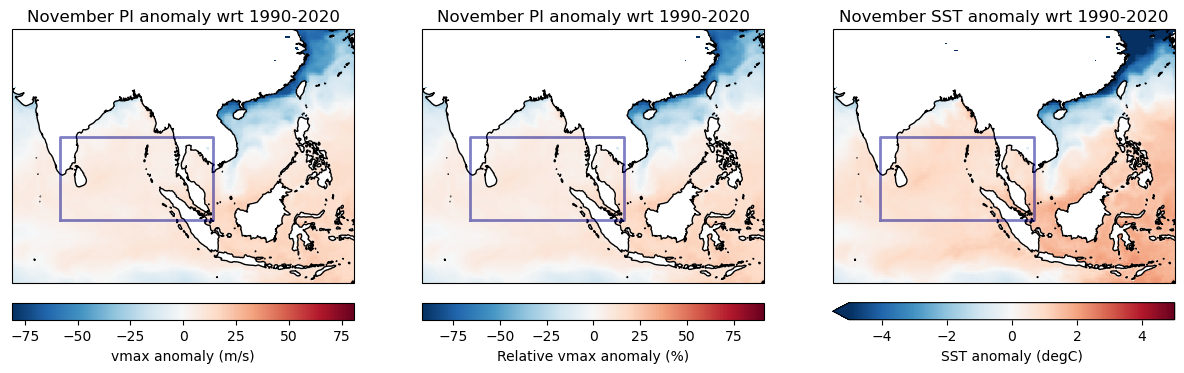

In [165]:
xn,xx,yn,yx = [77,105,0,15]
nc = 3
fig, axs = plt.subplots(ncols = nc, figsize = (nc*5,5), dpi = 100, subplot_kw = {"projection" : mapproj})
cbar_kwargs = {"location" : "bottom", "pad" : 0.05}

ax = axs[0]
pi_anom.plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "vmax anomaly (m/s)"})
ax.set_title("November PI anomaly wrt 1990-2020")

ax = axs[1]
pi_relanom.plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Relative vmax anomaly (%)"})
ax.set_title("November PI anomaly wrt 1990-2020")

ax = axs[2]
sst_anom.plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "SST anomaly (degC)"}, vmin = -5, vmax = 5, cmap = "RdBu_r")
ax.set_title("November SST anomaly wrt 1990-2020")

for ax in axs: 
    ax.coastlines()
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    # ax.gridlines(draw_labels = ["bottom", "left"])

plt.savefig("fig/anomaly-maps_pi+sst.png")


## Quick gridded trend

In [166]:
pi_nov = pi.groupby("time.month")[11].sel(time = slice("1950",None))
sst_nov = sst.groupby("time.month")[11].sel(time = slice("1950",None))

gmst = pd.read_table("data/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year").to_xarray().gmst.sel(year = pi_nov.time.dt.year)

In [167]:
pi_coeffs = pi_nov.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients
sst_coeffs = sst_nov.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients

pi_res = pi_nov.sel(time = "2025") -  xr.polyval(gmst.sel(time = "2025"), pi_coeffs)
sst_res = sst_nov.sel(time = "2025") -  xr.polyval(gmst.sel(time = "2025"), sst_coeffs)

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


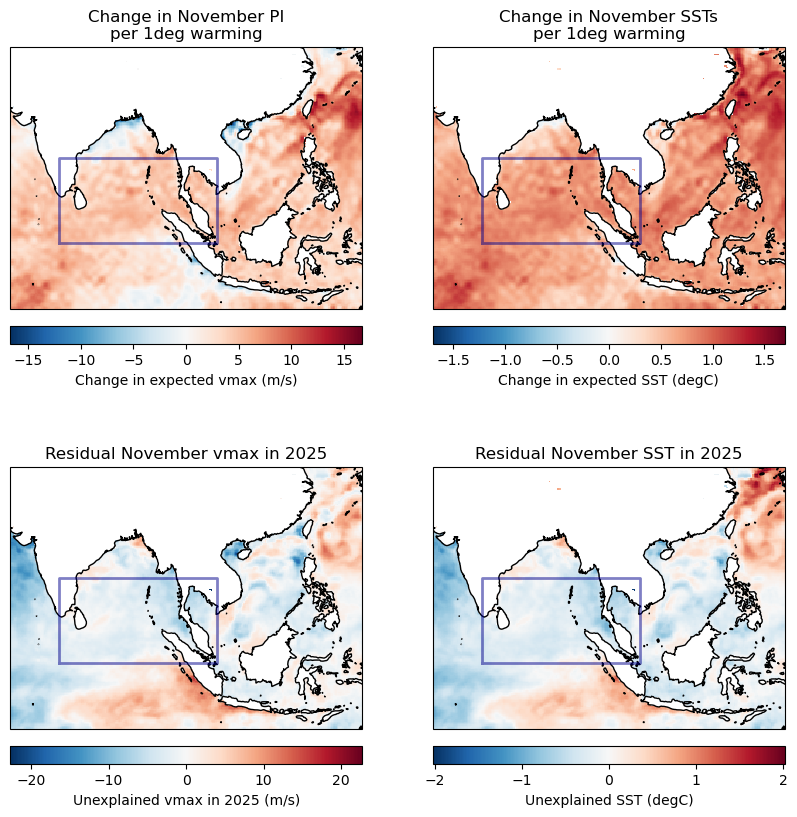

In [168]:
nc = 2; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5,nr*5), dpi = 100, subplot_kw = {"projection" : mapproj})
cbar_kwargs = {"location" : "bottom", "pad" : 0.05}

ax = axs[0,0]
pi_coeffs.sel(degree = 1).plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Change in expected vmax (m/s)"})
ax.set_title("Change in November PI\nper 1deg warming")

ax = axs[0,1]
sst_coeffs.sel(degree = 1).plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Change in expected SST (degC)"})
ax.set_title("Change in November SSTs\nper 1deg warming")


ax = axs[1,0]
pi_res.plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Unexplained vmax in 2025 (m/s)"})
ax.set_title("Residual November vmax in 2025")

ax = axs[1,1]
sst_res.plot(ax = ax, cbar_kwargs = cbar_kwargs | {"label" : "Unexplained SST (degC)"})
ax.set_title("Residual November SST in 2025")

for ax in axs.flatten(): 
    ax.coastlines()
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)

plt.savefig("fig/qtrendmaps_pi+sst.png")

## Quick look at time series over selected box

In [169]:
ts_pi = pi.sel(lon = slice(xn,xx), lat = slice(yx,yn)).mean(["lat", "lon"]).groupby("time.month")[11]
ts_sst = sst.sel(lon = slice(xn,xx), lat = slice(yx,yn)).mean(["lat", "lon"]).groupby("time.month")[11]

In [173]:
ts_pi.assign_coords(time = ts_pi.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/pi-nov_era5.csv")
ts_sst.assign_coords(time = ts_sst.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/sst-nov_era5.csv")

# Figure for report

In [19]:
xn,xx,yn,yx = [77,105,0,15]

pivars = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/SEAsiaFloods/potential-intensity/era5/era5_pivars-monthly.nc")
sst = pivars.sst

sst_nov = sst.groupby("time.month")[11].sel(time = slice("1950",None)).sel(lon = slice(None, 110), lat = slice(25, None))

In [31]:
sst_clim = sst_nov.sel(time = slice("1990","2020")).mean("time")
sst_anom = sst_nov.sel(time = "2025-11") - sst_clim

In [35]:
ts_sst = sst_nov.sel(lon = slice(xn,xx), lat = slice(yx,yn)).mean(["lat", "lon"])
ts_sst.assign_coords(time = ts_sst.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/sst-nov_era5.csv")

# linear trend in GMST
gmst = pd.read_table("data/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = "year").to_xarray().gmst.sel(year = sst_nov.time.dt.year)
sst_coeffs = ts_sst.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients
sst_fitted = xr.polyval(gmst, sst_coeffs)

# loess smoother over time
sst_sm = sm_lowess.lowess(ts_sst, ts_sst.time.dt.year, frac = 2/3)    # 'frac' determines the fraction of the data used to smooth each point - smaller frac means wigglier data (default is 2/3)
sst_sm = xr.DataArray(data = sst_sm[:,1], dims = ["time"], name = "z", coords = dict(ts_sst.coords))    # turn the smoothed values back into a dataarray so they're easier to plot

In [36]:
sf1 = gpd.read_file(fpath+"sf_SumatraMalayThai-LAND")
sf2 = gpd.read_file(fpath+"sf_SriLanka")

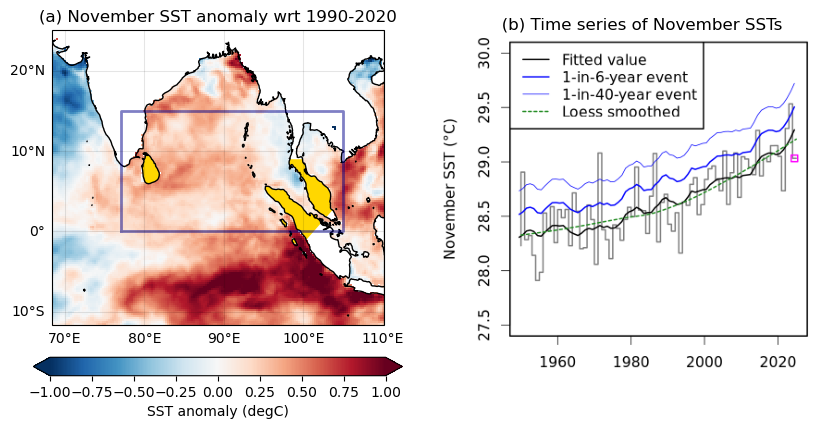

In [38]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,5), dpi = 100, gridspec_kw = {"width_ratios" : [1,1]})
plt.subplots_adjust(wspace = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
axs[0].set_axis_off()
ax = plt.subplot(121, projection = mapproj)

sst_anom.plot(ax = ax, cbar_kwargs = {"location" : "bottom", "pad" : 0.085, "label" : "SST anomaly (degC)"}, vmin = -1, vmax = 1, cmap = "RdBu_r")
ax.set_title("(a) November SST anomaly wrt 1990-2020")
ax.coastlines()
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)

ax.gridlines(draw_labels = ["left", "bottom"], color = "k", alpha = 0.1, ylocs = range(-10,30,10))

sf1.plot(ax = ax, color = "gold")
sf2.plot(ax = ax, color = "gold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
ax.set_axis_off()
img = Image.open('fig/trendplot_sst-era5_gmstonly.png')
ax.imshow(img)
ax.set_title("       (b) Time series of November SSTs")

plt.savefig("fig/sst-anomaly+trend.png")

## Write .dat file for climexp

In [14]:
csv_fnm = "SEA-floods_sst-era5"
csv_fullpath = "ts-dat/"+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 mean November SST over southern Bay of Bengal - SE Asia floods, 2025, c.barnes22@imperial.ac.uk"
str2 = "# sst [degc] mean November SSTs averaged over 77E-105E, 0-15N at "+csv_fnm+".dat"
head = "# year sst"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath

ts = ts_sst.assign_coords(time = ts_sst.time.dt.year).rename(time = "year").to_dataframe()
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)